In [1]:
import pickle

with open('data_predict.pkl','rb') as file:
    data = pickle.load(file)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 37 columns):
Type                             180519 non-null int32
Days for shipping (real)         180519 non-null int64
Days for shipment (scheduled)    180519 non-null int64
Benefit per order                180519 non-null float64
Sales per customer               180519 non-null float64
Category Id                      180519 non-null int64
Category Name                    180519 non-null int32
Customer City                    180519 non-null int32
Customer Country                 180519 non-null int32
Customer Id                      180519 non-null int64
Customer Lname                   180519 non-null int32
Customer Segment                 180519 non-null int32
Customer State                   180519 non-null int32
Customer Zipcode                 180519 non-null float64
Department Id                    180519 non-null int64
Department Name                  180519 non-null int32
Mar

In [3]:
# 查看预测标签
data['Sales per customer'].describe()

count    180519.000000
mean        183.107609
std         120.043670
min           7.490000
25%         104.379997
50%         163.990005
75%         247.399994
max        1939.989990
Name: Sales per customer, dtype: float64

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.distplot(data['Sales per customer'])
plt.show()
sns.distplot(np.log(data['Sales per customer']))
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [5]:
data['Order Item Quantity'].value_counts()

1    99134
5    20385
3    20350
4    20335
2    20315
Name: Order Item Quantity, dtype: int64

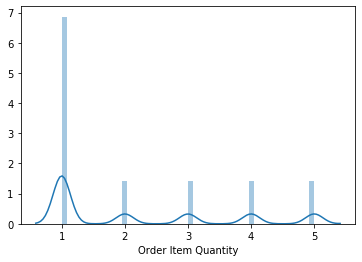

In [6]:
sns.distplot(data['Order Item Quantity'])
plt.show()

In [7]:
# 准备训练数据
x_sale = data.loc[:,data.columns != 'Sales per customer']
y_sale = data['Sales per customer']

x_order = data.loc[:,data.columns != 'Order Item Quantity']
y_order = data['Order Item Quantity']

In [8]:
# 切分数据集
from sklearn.model_selection import train_test_split

x_sale_train,x_sale_test,y_sale_train,y_sale_test = train_test_split(x_sale,y_sale,test_size = 0.2)
x_order_train,x_order_test,y_order_train,y_order_test = train_test_split(x_order,y_order,test_size = 0.2)

In [9]:
# 数据规范化
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
x_sale_train = ss.fit_transform(x_sale_train)
x_sale_test = ss.transform(x_sale_test)
x_order_train = ss.fit_transform(x_order_train)
x_order_test = ss.transform(x_order_test)

In [10]:
# 评估模型
from sklearn.metrics import mean_absolute_error,mean_squared_error

def model_evaluate(model_name,y_test,y_pred,task = 'sale'):
    mae = mean_absolute_error(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    rmse = mean_squared_error(y_test,y_pred,squared = False)
    print('{}采用{}预测的mae:{}'.format(task,model_name,mae))
    print('{}采用{}预测的mse:{}'.format(task,model_name,mse))
    print('{}采用{}预测的rmse:{}'.format(task,model_name,rmse))
    return model_name,mae,mse,rmse

In [11]:
# 创建模型：LinearRegression, Lasso, Ridge, DecisionTreeRegressor, XGBRegressor, LGBMRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

tasks = ['sale','order']
model_names = ['LinearRegression','Lasso','Ridge','DecisionTreeRegressor','XGBRegressor','LGBMRegressor','RandomForestRegressor']
models = [LinearRegression(),Lasso(),Ridge(),DecisionTreeRegressor(),XGBRegressor(),LGBMRegressor(),RandomForestRegressor()]
model_sale_stats = []
model_order_stats = []

for task in tasks:
    for model_name,model in zip(model_names,models):
        if task == 'sale':
            trained_model = model.fit(x_sale_train,y_sale_train)
            y_sale_pred = trained_model.predict(x_sale_test)
            model_sale_stat = model_evaluate(model_name,y_sale_test,y_sale_pred,task = 'sale')
            model_sale_stats.append(model_sale_stat)
        else:
            trained_model = model.fit(x_order_train,y_order_train)
            y_order_pred = trained_model.predict(x_order_test)
            model_order_stat = model_evaluate(model_name,y_order_test,y_order_pred,task = 'order')
            model_order_stats.append(model_order_stat)            

sale采用LinearRegression预测的mae:10.722397084300816
sale采用LinearRegression预测的mse:188.4563194367057
sale采用LinearRegression预测的rmse:13.727939373289267
sale采用Lasso预测的mae:11.645150203893143
sale采用Lasso预测的mse:208.82249576434126
sale采用Lasso预测的rmse:14.45069187839604
sale采用Ridge预测的mae:10.722545999315154
sale采用Ridge预测的mse:188.4562323339401
sale采用Ridge预测的rmse:13.727936200825676
sale采用DecisionTreeRegressor预测的mae:0.015334321756955573
sale采用DecisionTreeRegressor预测的mse:0.4883859570622756
sale采用DecisionTreeRegressor预测的rmse:0.6988461612274017
sale采用XGBRegressor预测的mae:0.218420383659499
sale采用XGBRegressor预测的mse:0.5791223251988066
sale采用XGBRegressor预测的rmse:0.7610008706951699
sale采用LGBMRegressor预测的mae:0.5781765890377522
sale采用LGBMRegressor预测的mse:1.4815294645991244
sale采用LGBMRegressor预测的rmse:1.2171809498177024
sale采用RandomForestRegressor预测的mae:0.0163309097814028
sale采用RandomForestRegressor预测的mse:0.23748739099297256
sale采用RandomForestRegressor预测的rmse:0.4873267805004898
order采用LinearRegression预测的mae:0.35311998002

In [15]:
# 基于mse得到最佳预测模型
import pandas as pd

def get_best_model(model_stats,x_train,y_train,task):
    df_model_stats = pd.DataFrame(model_stats,columns = ['model_name','mae','mse','rmse'])
    print(df_model_stats)
    best_model_name = df_model_stats.sort_values(by = 'mse')['model_name'].iloc[0]
    print('分析结论：最佳{}预测模型为 {}'.format(task,best_model_name))
    best_model = eval(best_model_name + "()")
    #print(best_model)
    best_model.fit(x_train,y_train)
    return best_model    

In [13]:
#获取模型特征及可视化
def get_important_feature(model,data,task):
    feature_col = model.feature_importances_.argsort()
    feature_importance = pd.DataFrame({'Variables':data.columns[feature_col],
                                      'importance':model.feature_importances_[feature_col]})
    print(feature_importance)
    plt.figure(figsize = (20,8))
    sns.catplot(x = 'Variables',y = 'importance',data = feature_importance,aspect = 2,kind = 'bar')
    plt.xticks(rotation = 90)
    plt.show()
    print('分析结论：对{}影响最大特征为{}'.format(task,data.columns[feature_col][-1]))

In [16]:
# 最佳销售预测模型
best_sale_model = get_best_model(model_sale_stats,x_sale_train,y_sale_train,'sale')

              model_name        mae         mse       rmse
0       LinearRegression  10.722397  188.456319  13.727939
1                  Lasso  11.645150  208.822496  14.450692
2                  Ridge  10.722546  188.456232  13.727936
3  DecisionTreeRegressor   0.015334    0.488386   0.698846
4           XGBRegressor   0.218420    0.579122   0.761001
5          LGBMRegressor   0.578177    1.481529   1.217181
6  RandomForestRegressor   0.016331    0.237487   0.487327
分析结论：最佳sale预测模型为 RandomForestRegressor
RandomForestRegressor()


                        Variables    importance
0                           fraud  1.422942e-09
1                      order_year  1.193225e-08
2                          Market  1.771463e-08
3                   late_delivery  6.748034e-08
4                   Shipping Mode  8.847752e-08
5   Days for shipment (scheduled)  9.570423e-08
6                Customer Country  1.187310e-07
7                   Order Country  1.530251e-07
8                  Customer State  1.608220e-07
9                    Order Region  2.168168e-07
10       Days for shipping (real)  2.763476e-07
11               Customer Segment  2.814749e-07
12               Customer Zipcode  2.975870e-07
13                           Type  4.834912e-07
14                  Customer City  6.346232e-07
15                     order_hour  6.835567e-07
16                 Customer Lname  7.741689e-07
17             Customer Full Name  9.508681e-07
18                     Order City  1.101607e-06
19        Order Item Profit Ratio  1.166

<Figure size 1440x576 with 0 Axes>

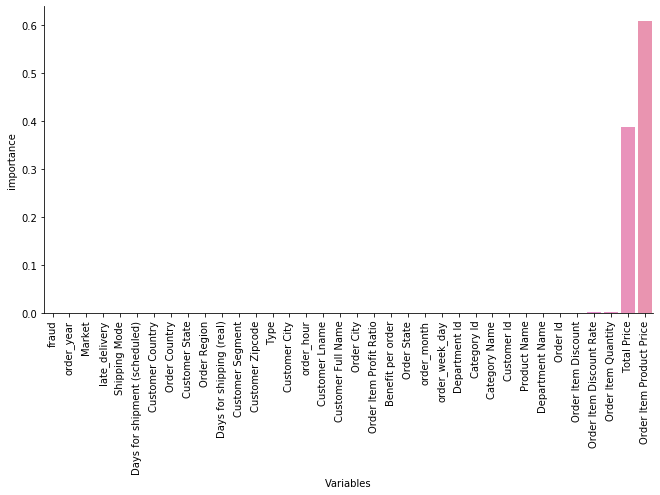

分析结论：对sale影响最大特征为Order Item Product Price


In [17]:
# 特征重要性可视化
get_important_feature(best_sale_model,x_sale,'sale')

In [18]:
# 最佳订单量预测模型
best_order_model = get_best_model(model_order_stats,x_order_train,y_order_train,'order')

              model_name       mae       mse      rmse
0       LinearRegression  0.353120  0.282329  0.531346
1                  Lasso  1.142985  1.714150  1.309256
2                  Ridge  0.353138  0.282329  0.531346
3  DecisionTreeRegressor  0.000222  0.000222  0.014886
4           XGBRegressor  0.000621  0.000052  0.007219
5          LGBMRegressor  0.001877  0.000175  0.013216
6  RandomForestRegressor  0.000194  0.000066  0.008096
分析结论：最佳order预测模型为 XGBRegressor
XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=N

                        Variables    importance
0                      order_year  0.000000e+00
1                   Shipping Mode  0.000000e+00
2                           fraud  0.000000e+00
3                Customer Country  0.000000e+00
4                   Department Id  1.093003e-08
5                   late_delivery  1.040499e-07
6                Customer Segment  2.414211e-07
7   Days for shipment (scheduled)  2.606421e-07
8                      order_hour  3.065063e-07
9                  Customer Lname  4.417154e-07
10        Order Item Profit Ratio  4.915258e-07
11                           Type  5.373706e-07
12             Customer Full Name  5.427589e-07
13                  Customer City  5.782539e-07
14       Days for shipping (real)  1.015979e-06
15                    Customer Id  1.224491e-06
16                    order_month  1.276007e-06
17                    Order State  1.551811e-06
18                     Order City  1.584514e-06
19                 order_week_day  2.244

<Figure size 1440x576 with 0 Axes>

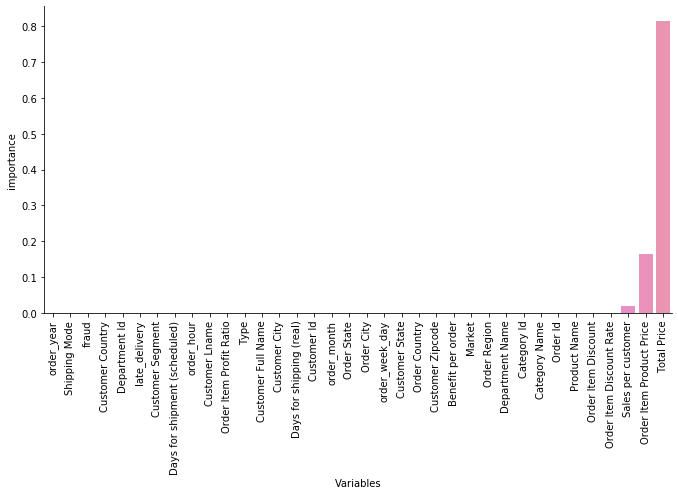

分析结论：对order影响最大特征为Total Price


In [20]:
# 订单量特征重要性分析
get_important_feature(best_order_model,x_order,'order')

In [42]:
# 使用neural network进行预测
import sys
sys.path.append('E:\Program Files\python\Lib\site-packages')
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization

# BN，对每个batch上的前一层数据进行规范化，是输出的均值为0，方差为1
BatchNormalization()
regressor = Sequential()
# 搭建神经网络
regressor.add(Dense(1024,activation = 'relu',input_dim = x_sale.shape[1]))
regressor.add(Dense(512,activation = 'relu'))
regressor.add(Dense(256,activation = 'relu'))
regressor.add(Dense(128,activation = 'relu'))
regressor.add(Dense(64,activation = 'relu'))
regressor.add(Dense(32,activation = 'relu'))
regressor.add(Dense(1,activation = 'relu'))
regressor.compile(optimizer = 'adam',loss = 'mean_squared_error',metrics = ['mae'])    

In [44]:
# sale模型训练
regressor.fit(x_sale_train,y_sale_train,batch_size = 1024,epochs =10)

Epoch 1/10
142/142 [==============================] - 6s 40ms/step - loss: 159.1930 - mae: 9.0972
Epoch 2/10
142/142 [==============================] - 6s 39ms/step - loss: 76.5258 - mae: 6.3402
Epoch 3/10
142/142 [==============================] - 6s 40ms/step - loss: 42.9760 - mae: 4.7334
Epoch 4/10
142/142 [==============================] - 6s 39ms/step - loss: 27.0881 - mae: 3.7339
Epoch 5/10
142/142 [==============================] - 6s 39ms/step - loss: 18.5889 - mae: 3.0727
Epoch 6/10
142/142 [==============================] - 6s 39ms/step - loss: 13.7031 - mae: 2.6391
Epoch 7/10
142/142 [==============================] - 6s 39ms/step - loss: 10.8115 - mae: 2.3526
Epoch 8/10
142/142 [==============================] - 6s 39ms/step - loss: 8.3997 - mae: 2.0734
Epoch 9/10
142/142 [==============================] - 6s 39ms/step - loss: 7.0179 - mae: 1.9027
Epoch 10/10
142/142 [==============================] - 6s 40ms/step - loss: 5.9034 - mae: 1.7541


In [45]:
# sale模型评估
sale_train_evaluate = regressor.evaluate(x_sale_train,y_sale_train)
sale_test_evaluate = regressor.evaluate(x_sale_test,y_sale_test)
print('sale_train_evaluation:',sale_train_evaluate)
print('sale_test_evaluation:',sale_test_evaluate)

1129/1129 [==============================] - 3s 3ms/step - loss: 8.0220 - mae: 2.1101
sale_train_evaluation: [6.930191516876221, 1.9904147386550903]
sale_test_evaluation: [8.021994590759277, 2.110053062438965]


In [46]:
# 输出sale预测结果
y_sale_pred = regressor.predict(x_sale_test,batch_size = 512,verbose =1)
# print(y_sale_pred)
print('sale预测MSE：',mean_squared_error(y_sale_test,y_sale_pred))

71/71 [==============================] - 1s 9ms/step
sale预测MSE： 8.021995326931755


In [47]:
# order模型训练
regressor.fit(x_order_train,y_order_train,batch_size = 1024,epochs = 10)

Epoch 1/10
142/142 [==============================] - 6s 40ms/step - loss: 397.0090 - mae: 2.8893
Epoch 2/10
142/142 [==============================] - 6s 39ms/step - loss: 0.1595 - mae: 0.2738
Epoch 3/10
142/142 [==============================] - 6s 39ms/step - loss: 0.0717 - mae: 0.1816
Epoch 4/10
142/142 [==============================] - 6s 39ms/step - loss: 0.0490 - mae: 0.1459
Epoch 5/10
142/142 [==============================] - 6s 40ms/step - loss: 0.0376 - mae: 0.1238
Epoch 6/10
142/142 [==============================] - 6s 39ms/step - loss: 0.0357 - mae: 0.1169
Epoch 7/10
142/142 [==============================] - 6s 40ms/step - loss: 0.0287 - mae: 0.1030
Epoch 8/10
142/142 [==============================] - 6s 41ms/step - loss: 0.0256 - mae: 0.0947
Epoch 9/10
142/142 [==============================] - 6s 39ms/step - loss: 0.0246 - mae: 0.0917
Epoch 10/10
142/142 [==============================] - 6s 39ms/step - loss: 0.0234 - mae: 0.0878


In [48]:
#order模型评估
order_train_evaluation = regressor.evaluate(x_order_train,y_order_train)
order_test_evaluation = regressor.evaluate(x_order_test,y_order_test)
print('order_train_evaluation:',order_train_evaluation)
print('order_test_evaluation',order_test_evaluation)

1129/1129 [==============================] - 5s 4ms/step - loss: 0.0446 - mae: 0.1316
order_train_evaluation: [0.04409656673669815, 0.13066911697387695]
order_test_evaluation [0.04462079331278801, 0.13157857954502106]


In [49]:
# 输出sale预测结果
y_order_pred = regressor.predict(x_order_test,batch_size = 512,verbose =1)
# print(y_sale_pred)
print('order预测MSE：',mean_squared_error(y_order_test,y_order_pred))

71/71 [==============================] - 1s 9ms/step
order预测MSE： 0.04462079099527141
